In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashok\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [7]:
data= pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

In [8]:
data.shape

(1599999, 6)

In [9]:
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [10]:
column=['output','id','date','flag','user','text']
data= pd.read_csv('training.1600000.processed.noemoticon.csv', names=column,encoding='ISO-8859-1')

In [11]:
data.head()

,output,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
data.isnull().sum()

output    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [13]:
data['output'].value_counts()


output
0    800000
4    800000
Name: count, dtype: int64

In [14]:
data.replace({'output':{4:1}}, inplace=True)

In [15]:
data['output'].value_counts()

output
0    800000
1    800000
Name: count, dtype: int64

In [16]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [17]:
stop_words = set(stopwords.words('english'))
def stemming(content):
    try:
        port_stem=PorterStemmer()
        stemmed= re.sub('[^a-zA-Z]',' ',content).lower()
        return ' '.join(port_stem.stem(word) for word in stemmed.split() if not word in stop_words)
    except Exception as e:
        print(f"Error processing content: {content}.Error={e}")
        return ""
def process_data(df):
    with ThreadPoolExecutor() as executor:
        return list(tqdm(executor.map(stemming,df['text']),total=len(df)))

chunk_size=50000
num_chunk=len(data)//chunk_size+1
stemmed_con=[]

for i in tqdm(range(num_chunk)):
    start = i*chunk_size
    end = min((i+1)*chunk_size,len(data))
    chunk=data.iloc[start:end]
    stemmed_chunk = process_data(chunk)
    stemmed_con.extend(stemmed_chunk)

data['stemmed_text'] = stemmed_con 


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 32/33 [07:37<00:13, 13.91s/it]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [07:37<00:00, 13.86s/it]


In [18]:
data.head()

,output,id,date,flag,user,text,stemmed_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [43]:
X=data["stemmed_text"].values
Y=data["output"].values

In [54]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2, random_state=34)

In [55]:
vectorizer = TfidfVectorizer(max_features=20000) 
x_train = vectorizer.fit_transform(x_train)
x_test= vectorizer.transform(x_test)

In [53]:
import gc

del X_train, X_test
gc.collect()  

11694

In [60]:
classification = LogisticRegression(max_iter=5000)

In [61]:
classification= classification.fit(x_train,y_train)

In [62]:
Y_pred=classification.predict(x_test)
accuracy=accuracy_score(y_test,Y_pred)

In [63]:
print(accuracy)

0.7733125


In [53]:
import pickle

In [78]:
filename = 'ML_model_16.sav'
pickle.dump(classification,open(filename, 'wb'))

In [79]:
filename_1='vectorizer.sav'
pickle.dump(vectorizer,open(filename_1,'wb'))

In [57]:
model=pickle.load(open('ML_model_16.sav','rb'))

In [ ]:
inp = input("enter the sentiment: ")
X= [inp]
X= vectorizer.transform(X)
pred= model.predict(X)
if(pred[0]==0):
    print('Negative Sentiment')
else:
    print('Positive Sentiment')

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm= confusion_matrix(Y_test,Y_pred,labels=[0,1])

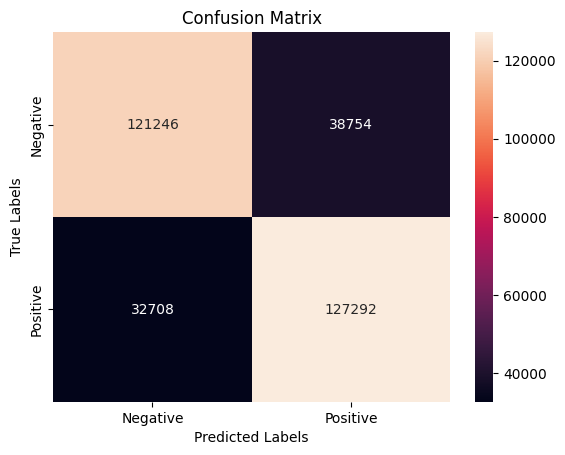

In [102]:
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()